## EDA

- https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey

In [15]:
import re

import numpy as np
import polars as pl
import matplotlib.pyplot as plt

### Inspect train and test csv data

train.csv

- eeg_id: 脳波ID (unique)
- eeg_sub_id: labelが適用される特定の50sのsubsample ID
- eeg_label_offset_seconds: 連結EEGの開始からこのsubsampleまでの時間
- spectrogram_id: スペクトログラムID (unique) - eeg_idと役割としては同じに思える
- spectrogram_sub_id: labelが適用される特定の10minのsubsampleID
- spectrogram_label_offset_seconds: 連結spectrogramの開始からこのsubsampleまでの時間
- label_id: ラベルID
- patient_id: 患者ID
- expert_consensus: 専門家の合意 - 便宜上記載とあるので、あまり重要視しなくて良さげ
- (seizure|lpd|gpd|lrda|grda|other)_vote: 投票数

In [3]:
train_dataset = pl.read_csv("/kaggle/input/train.csv")

train_dataset

eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0
1628180742,5,26.0,353733,5,26.0,2413091605,42516,"""Seizure""",3,0,0,0,0,0
1628180742,6,30.0,353733,6,30.0,364593930,42516,"""Seizure""",3,0,0,0,0,0
1628180742,7,36.0,353733,7,36.0,3811483573,42516,"""Seizure""",3,0,0,0,0,0
1628180742,8,40.0,353733,8,40.0,3388718494,42516,"""Seizure""",3,0,0,0,0,0


test.csv

- eeg_id
- spectrogram_id
- patient_id

In [4]:
test_dataset = pl.read_csv("/kaggle/input/test.csv")

test_dataset

spectrogram_id,eeg_id,patient_id
i64,i64,i64
853520,3911565283,6885


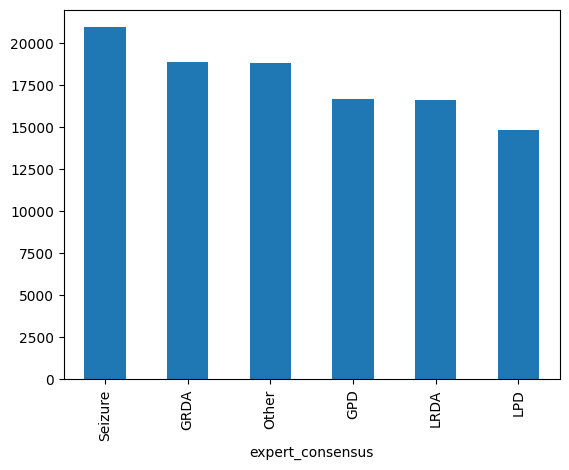

In [5]:
train_dataset.to_pandas()["expert_consensus"].value_counts().plot(kind='bar')

# プロットを表示
plt.show()

In [6]:
print(f"Number of patients: {train_dataset['patient_id'].n_unique()}")

Number of patients: 1950


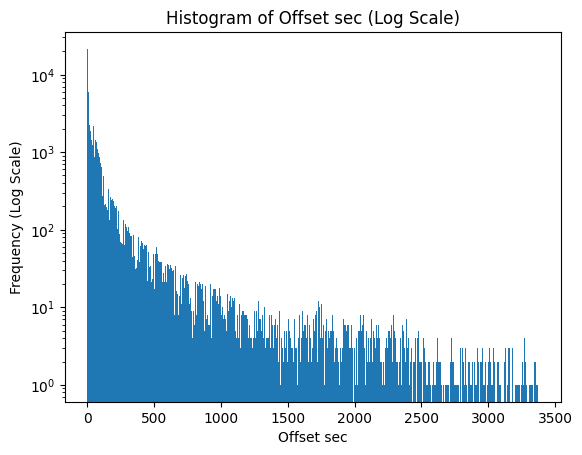

In [7]:
plt.Figure(figsize=(10, 6))
plt.hist(train_dataset["eeg_label_offset_seconds"], bins="auto", log=True)
plt.xlabel("Offset sec")
plt.ylabel("Frequency (Log Scale)")
plt.title("Histogram of Offset sec (Log Scale)")
plt.show()


### Explore train EEGs



In [8]:
print("Train eeg files: ")
! ls /kaggle/input/train_eegs | wc -l

print("Size of train eegs: ")
! du -sh /kaggle/input/train_eegs

Train eeg files: 
17300
Size of train eegs: 
18G	/kaggle/input/train_eegs


In [9]:
sample_train_eeg = pl.read_parquet("/kaggle/input/train_eegs/1000913311.parquet")

sample_train_eeg

Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
-105.849998,-89.230003,-79.459999,-49.23,-99.730003,-87.769997,-53.330002,-50.740002,-32.25,-42.099998,-43.27,-88.730003,-74.410004,-92.459999,-58.93,-75.739998,-59.470001,8.21,66.489998,1404.930054
-85.470001,-75.07,-60.259998,-38.919998,-73.080002,-87.510002,-39.68,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.32,-35.790001,-58.900002,-41.66,196.190002,230.669998,3402.669922
8.84,34.849998,56.43,67.970001,48.099998,25.35,80.25,48.060001,6.72,37.880001,61.0,16.58,55.060001,45.02,70.529999,47.82,72.029999,-67.18,-171.309998,-3565.800049
-56.32,-37.279999,-28.1,-2.82,-43.43,-35.049999,3.91,-12.66,8.65,3.83,4.18,-51.900002,-21.889999,-41.330002,-11.58,-27.040001,-11.73,-91.0,-81.190002,-1280.930054
-110.139999,-104.519997,-96.879997,-70.25,-111.660004,-114.43,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.07,-89.25,-77.260002,155.729996,264.850006,4325.370117
-20.690001,-0.45,20.299999,33.919998,13.21,-15.23,42.98,22.129999,-35.619999,-5.82,22.860001,-10.2,17.629999,11.2,38.549999,14.34,36.18,1.84,-51.150002,-1490.189941
-36.490002,-8.83,2.9,26.200001,-10.08,-14.21,33.900002,10.49,12.04,17.709999,26.35,-26.76,6.11,-10.38,18.24,-1.37,16.879999,-161.600006,-212.830002,-3514.159912
-131.610001,-120.480003,-115.830002,-83.410004,-133.039993,-128.690002,-81.129997,-73.720001,-70.269997,-83.489998,-76.239998,-117.599998,-111.260002,-125.669998,-87.889999,-108.980003,-98.349998,89.169998,197.089996,3567.330078
-59.189999,-43.599998,-27.73,-10.65,-36.27,-62.259998,2.05,-9.66,-69.309998,-46.119999,-17.32,-49.610001,-32.849998,-36.34,-3.84,-30.280001,-14.37,102.269997,102.129997,1223.910034


- 列 -> 脳につけた特定の電極からの値を示す
- 行 -> この電極からの経時的な値を示す
  - 頻度は毎秒200sample(行)
  - 10_000rows / 200samples = 50s間の計測結果

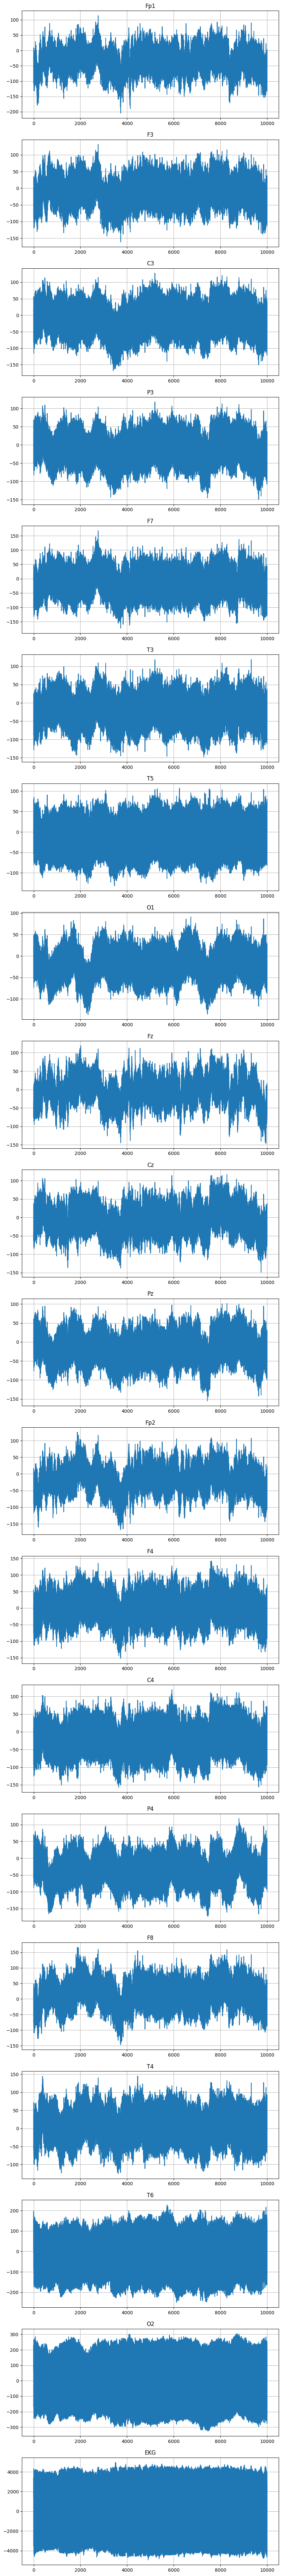

In [10]:
# 可視化
fig, ax = plt.subplots(20, figsize=(10, 100))

sample_train_eeg = sample_train_eeg.to_pandas()

# 各列に対して、プロットしていく
for i, column in enumerate(sample_train_eeg.columns):
  ax[i].plot(sample_train_eeg.index, sample_train_eeg[column], label=column)
  ax[i].grid(True)
  ax[i].set_title(str(column))

plt.show()

### Explore train spectrograms

In [11]:
sample_train_spectrogram = pl.read_parquet("/kaggle/input/train_spectrograms/1000086677.parquet")

sample_train_spectrogram

time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,LL_2.54,LL_2.73,LL_2.93,LL_3.13,LL_3.32,LL_3.52,LL_3.71,LL_3.91,LL_4.1,LL_4.3,LL_4.49,LL_4.69,LL_4.88,LL_5.08,LL_5.27,LL_5.47,LL_5.66,LL_5.86,LL_6.05,LL_6.25,LL_6.45,LL_6.64,LL_6.84,LL_7.03,LL_7.23,LL_7.42,…,RP_12.89,RP_13.09,RP_13.28,RP_13.48,RP_13.67,RP_13.87,RP_14.06,RP_14.26,RP_14.45,RP_14.65,RP_14.84,RP_15.04,RP_15.23,RP_15.43,RP_15.63,RP_15.82,RP_16.02,RP_16.21,RP_16.41,RP_16.6,RP_16.8,RP_16.99,RP_17.19,RP_17.38,RP_17.58,RP_17.77,RP_17.97,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,28.68,53.990002,67.629997,59.880001,50.880001,74.309998,78.480003,63.080002,59.869999,62.939999,19.01,15.21,15.1,14.57,12.15,9.24,10.43,8.72,3.82,4.4,3.34,2.39,3.62,2.76,2.83,4.34,3.14,4.1,2.92,2.9,2.45,1.79,1.77,1.71,1.52,1.41,…,0.25,0.23,0.2,0.14,0.17,0.22,0.2,0.2,0.26,0.24,0.24,0.2,0.19,0.12,0.07,0.1,0.14,0.09,0.11,0.1,0.05,0.08,0.08,0.05,0.1,0.08,0.06,0.13,0.14,0.08,0.11,0.04,0.03,0.05,0.05,0.04,0.05
3,29.639999,38.959999,44.009998,66.800003,48.509998,42.18,47.34,48.599998,40.880001,27.93,31.690001,19.129999,18.6,14.95,10.55,6.35,8.2,9.03,8.13,8.48,8.5,5.86,5.0,6.26,3.92,3.99,3.57,2.66,2.13,2.01,1.96,1.51,1.55,2.3,2.7,2.76,…,0.44,0.37,0.2,0.25,0.4,0.45,0.41,0.39,0.41,0.38,0.39,0.39,0.24,0.13,0.17,0.18,0.17,0.17,0.15,0.17,0.2,0.17,0.16,0.1,0.05,0.11,0.1,0.15,0.13,0.08,0.08,0.07,0.06,0.07,0.06,0.06,0.06
5,8.89,9.02,16.360001,23.559999,27.34,30.040001,27.559999,23.290001,15.12,13.53,17.200001,13.51,11.85,10.68,5.49,3.83,3.82,4.53,6.89,6.82,5.87,5.87,4.35,2.55,2.36,2.38,2.07,1.74,1.49,1.29,1.06,0.86,0.8,0.95,1.28,1.55,…,0.38,0.22,0.22,0.43,0.53,0.39,0.44,0.25,0.16,0.27,0.28,0.31,0.35,0.22,0.18,0.15,0.21,0.21,0.24,0.29,0.22,0.21,0.17,0.19,0.11,0.12,0.13,0.12,0.11,0.08,0.08,0.09,0.1,0.12,0.14,0.13,0.14
7,1.77,1.93,1.81,1.6,1.43,1.28,1.19,1.11,1.01,0.9,0.81,0.73,0.64,0.55,0.48,0.42,0.36,0.32,0.28,0.25,0.23,0.2,0.18,0.16,0.14,0.12,0.1,0.07,0.05,0.04,0.02,0.01,0.01,0.01,0.01,0.02,…,0.1,0.09,0.08,0.07,0.07,0.06,0.06,0.06,0.06,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04
9,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
11,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
13,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
15,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
17,null,null,

In [22]:
def plot_spectrogram(spectrogram_path):
  sample_spect = pl.read_parquet(spectrogram_path)

  # 正規表現パターンに一致する列名を選択
  split_spect = {
    "LL": sample_spect.select([col for col in sample_spect.columns if re.compile("^LL").match(col)]),
    "RL": sample_spect.select([col for col in sample_spect.columns if re.compile("^RL").match(col)]),
    "RP": sample_spect.select([col for col in sample_spect.columns if re.compile("^RP").match(col)]),
    "LP": sample_spect.select([col for col in sample_spect.columns if re.compile("^LP").match(col)]),
  }

  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
  axes = axes.flatten()

  label_interval = 5
  for i, split_name in enumerate(split_spect.keys()):
    ax = axes[i]
    img = ax.imshow(np.log(split_spect[split_name]).T, cmap="viridis", aspect="auto", origin="lower")

    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label("Log(Value)")
    ax.set_title(split_name)
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time")

    ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
    ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])

    frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]

    ax.set_yticks(
      np.arange(
        0,
        len(split_spect[split_name].columns),
        label_interval,
      ),
    )

    ax.set_yticklabels(frequencies[::label_interval])

  plt.tight_layout()
  plt.show()

/tmp/ipykernel_5006/3156846356.py:18: RuntimeWarning: divide by zero encountered in log
  img = ax.imshow(np.log(split_spect[split_name]).T, cmap="viridis", aspect="auto", origin="lower")


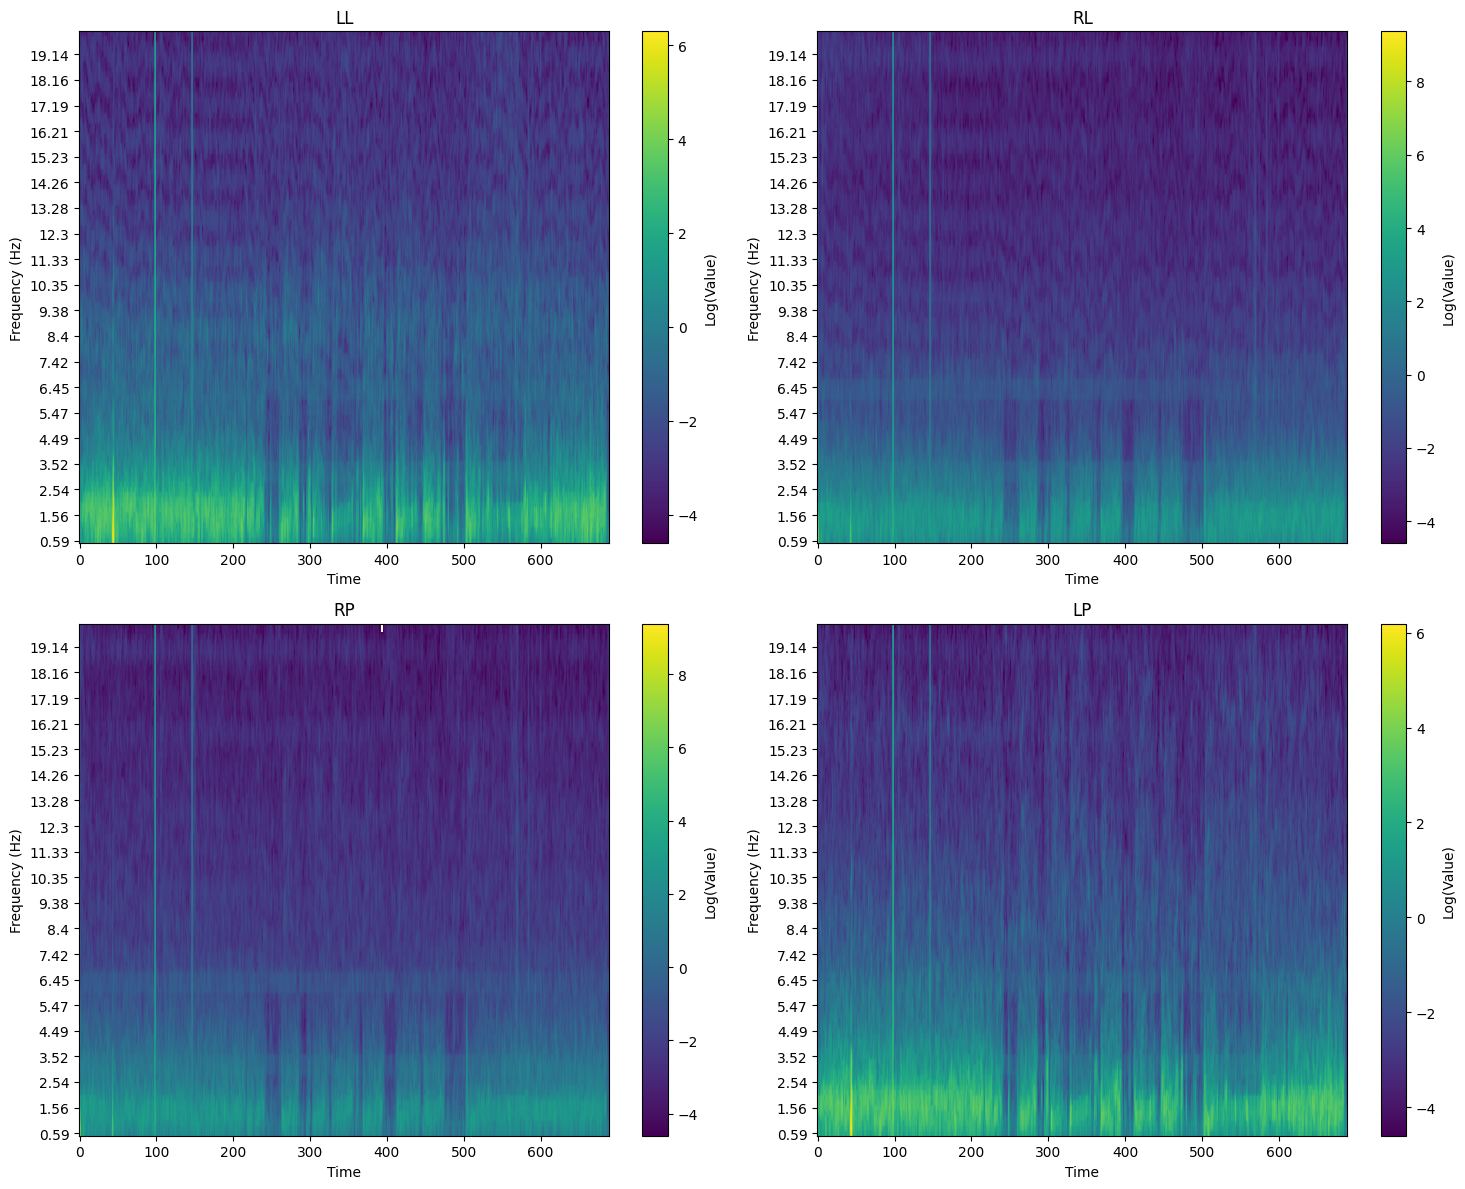

In [23]:
plot_spectrogram("/kaggle/input/train_spectrograms/1000189855.parquet")